In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

# Load the dataset
data = pd.read_csv("E:/MKNN/Final/Crop_Recommendation.csv")

# Split data into features and target
X = data.drop('target', axis=1)
y = data['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

def weighted_knn(X_train, y_train, X_test, k=3):
    """
    Weighted K-Nearest Neighbors implementation.
    
    Args:
    - X_train: Training features
    - y_train: Training labels
    - X_test: Test features
    - k: Number of neighbors to consider
    
    Returns:
    - y_pred: Predicted labels for the test set
    """
    def compute_weights(distances):
        """
        Compute weights as the inverse of distances.
        Avoid division by zero by adding a small constant (epsilon).
        """
        epsilon = 1e-5
        return 1 / (distances + epsilon)

    y_pred = []
    for test_point in X_test.values:
        # Compute distances to all training points
        distances = np.linalg.norm(X_train.values - test_point, axis=1)
        
        # Find the indices of the k-nearest neighbors
        nearest_indices = np.argsort(distances)[:k]
        
        # Get the labels of the k-nearest neighbors
        nearest_labels = y_train.iloc[nearest_indices].values
        
        # Compute weights for the k-nearest neighbors
        nearest_weights = compute_weights(distances[nearest_indices])
        
        # Perform weighted vote
        label_weights = {}
        for label, weight in zip(nearest_labels, nearest_weights):
            label_weights[label] = label_weights.get(label, 0) + weight
        
        # Predict the label with the highest weight
        predicted_label = max(label_weights, key=label_weights.get)
        y_pred.append(predicted_label)
    
    return np.array(y_pred)

# Apply W-KNN
k = 100
y_pred = weighted_knn(X_train, y_train, X_test, k=k)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Weighted KNN: {accuracy * 100:.2f}%")


Accuracy of Weighted KNN: 89.98%


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def condensed_nearest_neighbor(X_train, y_train):
    """
    Condensed Nearest Neighbor (CNN) implementation.
    
    Args:
    - X_train: Training features
    - y_train: Training labels
    
    Returns:
    - X_condensed: Condensed feature set
    - y_condensed: Condensed label set
    """
    X_train = X_train.values  # Convert to numpy for efficient computation
    y_train = y_train.values

    # Initialize condensed set with a single random point
    indices = np.random.permutation(len(X_train))
    X_condensed = [X_train[indices[0]]]
    y_condensed = [y_train[indices[0]]]

    changed = True
    while changed:
        changed = False
        for i, x_i in enumerate(X_train):
            # Predict using the current condensed set
            distances = np.linalg.norm(np.array(X_condensed) - x_i, axis=1)
            nearest_index = np.argmin(distances)
            predicted_label = y_condensed[nearest_index]
            
            # If misclassified, add to the condensed set
            if predicted_label != y_train[i]:
                X_condensed.append(x_i)
                y_condensed.append(y_train[i])
                changed = True
    
    return np.array(X_condensed), np.array(y_condensed)

# Load the dataset
data = pd.read_csv("E:/MKNN/Final/Crop_Recommendation.csv")
X = data.drop('target', axis=1)
y = data['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply Condensed Nearest Neighbor
X_condensed, y_condensed = condensed_nearest_neighbor(X_train, y_train)

# Evaluate the reduced dataset
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_condensed, y_condensed)
y_pred = knn.predict(X_test)

# Print results
original_size = len(X_train)
reduced_size = len(X_condensed)
accuracy = accuracy_score(y_test, y_pred)

print(f"Original training set size: {original_size}")
print(f"Condensed training set size: {reduced_size}")
print(f"Reduction in size: {100 * (1 - reduced_size / original_size):.2f}%")
print(f"Accuracy with condensed dataset: {accuracy * 100:.2f}%")


Original training set size: 1536
Condensed training set size: 161
Reduction in size: 89.52%
Accuracy with condensed dataset: 87.25%


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

def condensed_nearest_neighbor(X_train, y_train):
    """
    Condensed Nearest Neighbor (CNN) implementation.
    """
    X_train = X_train.values
    y_train = y_train.values
    X_condensed = [X_train[0]]
    y_condensed = [y_train[0]]

    changed = True
    while changed:
        changed = False
        for i, x_i in enumerate(X_train):
            distances = np.linalg.norm(np.array(X_condensed) - x_i, axis=1)
            nearest_index = np.argmin(distances)
            predicted_label = y_condensed[nearest_index]

            if predicted_label != y_train[i]:
                X_condensed.append(x_i)
                y_condensed.append(y_train[i])
                changed = True

    return np.array(X_condensed), np.array(y_condensed)

def reduced_nearest_neighbor(X_condensed, y_condensed):
    """
    Reduced Nearest Neighbor (RNN) implementation.
    """
    X_condensed = list(X_condensed)
    y_condensed = list(y_condensed)
    
    for i in range(len(X_condensed) - 1, -1, -1):  # Iterate in reverse to avoid indexing issues
        # Temporarily remove the point
        test_point = X_condensed.pop(i)
        test_label = y_condensed.pop(i)
        
        # Train a k-NN classifier with the remaining points
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(X_condensed, y_condensed)
        
        # Check if the point can be removed
        predicted_label = knn.predict([test_point])[0]
        if predicted_label != test_label:
            # If misclassified, add it back
            X_condensed.insert(i, test_point)
            y_condensed.insert(i, test_label)

    return np.array(X_condensed), np.array(y_condensed)

# Load the dataset
data = pd.read_csv("E:/MKNN/Final/Crop_Recommendation.csv")
X = data.drop('target', axis=1)
y = data['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 1: Obtain the condensed set using CNN
X_condensed, y_condensed = condensed_nearest_neighbor(X_train, y_train)

# Step 2: Apply RNN to refine the condensed set
X_reduced, y_reduced = reduced_nearest_neighbor(X_condensed, y_condensed)

# Evaluate the reduced dataset
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_reduced, y_reduced)
y_pred = knn.predict(X_test)

# Print results
original_size = len(X_train)
condensed_size = len(X_condensed)
reduced_size = len(X_reduced)
accuracy = accuracy_score(y_test, y_pred)

print(f"Original training set size: {original_size}")
print(f"Condensed training set size: {condensed_size}")
print(f"Reduced training set size: {reduced_size}")
print(f"Reduction in size after RNN: {100 * (1 - reduced_size / original_size):.2f}%")
print(f"Accuracy with reduced dataset: {accuracy * 100:.2f}%")


Original training set size: 1536
Condensed training set size: 157
Reduced training set size: 114
Reduction in size after RNN: 92.58%
Accuracy with reduced dataset: 85.28%


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

def edited_nearest_neighbor(X_train, y_train, k=3):
    """
    Edited Nearest Neighbor (ENN) implementation.
    
    Args:
    - X_train: Training features
    - y_train: Training labels
    - k: Number of neighbors to consider
    
    Returns:
    - X_edited: Edited feature set
    - y_edited: Edited label set
    """
    X_train = X_train.values  # Convert to numpy for efficient computation
    y_train = y_train.values

    changed = True
    while changed:
        changed = False
        for i in range(len(X_train)):
            # Get the k-nearest neighbors of the current point
            distances = np.linalg.norm(X_train - X_train[i], axis=1)
            nearest_indices = np.argsort(distances)[1:k+1]  # Exclude the point itself

            # Get the labels of the k-nearest neighbors
            nearest_labels = y_train[nearest_indices]

            # If the label of the point does not match the majority of its neighbors, remove it
            majority_label = Counter(nearest_labels).most_common(1)[0][0]
            if y_train[i] != majority_label:
                # Remove point from training set
                X_train = np.delete(X_train, i, axis=0)
                y_train = np.delete(y_train, i)
                changed = True
                break  # Re-evaluate from the start due to dataset modification

    return X_train, y_train

# Load the dataset
data = pd.read_csv("E:/MKNN/Final/Crop_Recommendation.csv")
X = data.drop('target', axis=1)
y = data['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply Edited Nearest Neighbor (ENN)
X_edited, y_edited = edited_nearest_neighbor(X_train, y_train, k=100)

# Evaluate the edited dataset
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_edited, y_edited)
y_pred = knn.predict(X_test)

# Print results
original_size = len(X_train)
edited_size = len(X_edited)
accuracy = accuracy_score(y_test, y_pred)

print(f"Original training set size: {original_size}")
print(f"Edited training set size: {edited_size}")
print(f"Reduction in size: {100 * (1 - edited_size / original_size):.2f}%")
print(f"Accuracy with edited dataset: {accuracy * 100:.2f}%")


Original training set size: 1536
Edited training set size: 1091
Reduction in size: 28.97%
Accuracy with edited dataset: 71.93%


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

def selective_nearest_neighbor(X_train, y_train, X_query, k=3, threshold=0.5):
    """
    Selective Nearest Neighbor (SNN) implementation.
    
    Args:
    - X_train: Training feature set
    - y_train: Training labels
    - X_query: Query point (single data point for classification)
    - k: Number of nearest neighbors to consider
    - threshold: Similarity threshold to select relevant neighbors
    
    Returns:
    - predicted_label: Predicted label for the query point
    """
    # Calculate Euclidean distances between query point and all training points
    distances = np.linalg.norm(X_train - X_query, axis=1)
    
    # Get the indices of the k nearest neighbors
    nearest_indices = np.argsort(distances)[:k]
    
    # Get the labels of the k nearest neighbors
    nearest_labels = y_train[nearest_indices]
    
    # Select relevant neighbors based on a similarity threshold (distance-based)
    relevant_neighbors = []
    for i in range(1, len(nearest_labels)):
        if distances[nearest_indices[i]] - distances[nearest_indices[i - 1]] < threshold:
            relevant_neighbors.append(nearest_labels[i])

    if len(relevant_neighbors) > 0:
        # Majority voting among relevant neighbors
        predicted_label = np.bincount(relevant_neighbors).argmax()
    else:
        # If no relevant neighbors, default to majority voting of all neighbors
        predicted_label = np.bincount(nearest_labels).argmax()
    
    return predicted_label

# Load the dataset
data = pd.read_csv("E:/MKNN/Final/Crop_Recommendation.csv")
X = data.drop('target', axis=1)
y = data['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Evaluate the SNN classifier
predictions = []
for i in range(len(X_test)):
    query_point = X_test.iloc[i].values
    predicted_label = selective_nearest_neighbor(X_train.values, y_train.values, query_point, k=100, threshold=0.5)
    predictions.append(predicted_label)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy with Selective Nearest Neighbor (SNN): {accuracy * 100:.2f}%")


Accuracy with Selective Nearest Neighbor (SNN): 82.09%


<Figure size 800x800 with 0 Axes>

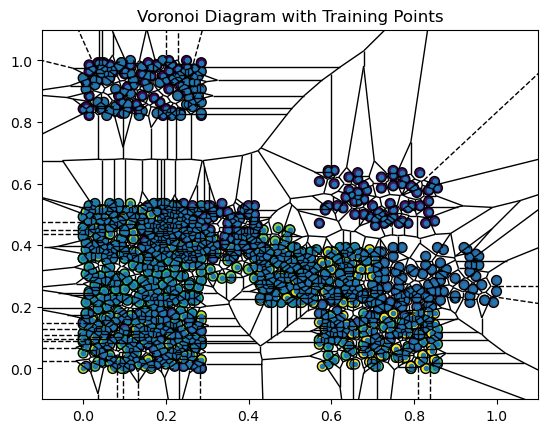

Accuracy with Voronoi Boundary Nearest Neighbor (VBNN): 37.78%


In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

def voronoi_boundary_nearest_neighbor(X_train, y_train, X_query, k=3):
    """
    Voronoi Boundary Nearest Neighbor (VBNN) implementation.
    
    Args:
    - X_train: Training feature set
    - y_train: Training labels
    - X_query: Query point (single data point for classification)
    - k: Number of nearest neighbors to consider
    
    Returns:
    - predicted_label: Predicted label for the query point
    """
    # Calculate Euclidean distances between query point and all training points
    distances = np.linalg.norm(X_train - X_query, axis=1)
    
    # Get the indices of the k nearest neighbors
    nearest_indices = np.argsort(distances)[:k]
    
    # Get the labels of the k nearest neighbors
    nearest_labels = y_train[nearest_indices]
    
    # Majority voting among k nearest neighbors
    predicted_label = np.bincount(nearest_labels).argmax()
    
    return predicted_label

def plot_voronoi(X_train, y_train):
    """
    Plot Voronoi diagram for the training data points.
    
    Args:
    - X_train: Training feature set
    - y_train: Training labels
    """
    # Generate Voronoi diagram
    vor = Voronoi(X_train)
    
    # Plot the Voronoi diagram
    plt.figure(figsize=(8, 8))
    voronoi_plot_2d(vor, show_vertices=False)
    
    # Scatter plot of the training data points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolors='k', s=50)
    plt.title("Voronoi Diagram with Training Points")
    plt.show()

# Load the dataset
data = pd.read_csv("E:/MKNN/Final/Crop_Recommendation.csv")
X = data.drop('target', axis=1)
y = data['target']

# If the dataset is multi-dimensional, reduce to two dimensions for visualization purposes (optional)
# For example, we'll use the first two features for demonstration.
X_2d = X.iloc[:, :2]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_2d, y, test_size=0.3, random_state=42, stratify=y)

# Plot Voronoi diagram for the training set
plot_voronoi(X_train.values, y_train.values)

# Evaluate the VBNN classifier
predictions = []
for i in range(len(X_test)):
    query_point = X_test.iloc[i].values
    predicted_label = voronoi_boundary_nearest_neighbor(X_train.values, y_train.values, query_point, k=3)
    predictions.append(predicted_label)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy with Voronoi Boundary Nearest Neighbor (VBNN): {accuracy * 100:.2f}%")
